# 1.1 Curating external datasets
### Background
Data tends to be scarce and sparse in the biochemistry world. Due to the time consuming and costly nature of lab experiments, it is not always feasible to generate the tens to hundreds of thousands of data points potentially needed to train machine learning models (depending on the complexity of the model and the nature of the data). We therefore want to be able to supplement our model training with data from external, publicly available sources, such as PubChem, ChEMBL, Uniprot, etc.  

To make these datasets amenable to training, they have to be processed and cleaned. This protocol will walk you through necessary bare minimum data transformation and cleaning that your external data has to undergo to be amenable to modeling.  

**NOTE**: There is no real one-size-fits-all approach to data curation given the variety of use cases. Some experimentation and iteration 
may be necessary.  Additionally this represents the **MINIMUM** level of curation needed to get a dataset like this fed into a machine learning model. Additional processing steps (normalization, outlier detection etc) are likely required to get build the best models possible. 


### Requirements
For this process in general, you need an external dataset that is in a file format readable by `pandas`, e.g. `.csv`, `.parquet`, `.xlsx`, `.xls`. The dataset must, at minimum, include:  
1. a column of SMILES strings  
2. a column of compound activity measured as one of the following: `'IC50', 'XC50', 'EC50', 'AC50', 'Ki', 'Kd', 'Potency'`  

## 1. Overview
In this demo notebook, we'll show you how to process a datasets from two open source repositories: PubChem and ChEMBL.  

## 2. Curating a ChEMBL dataset
To make the data compatible for model training in our workflow, the following columns must be created:

- `OPENADMET_CANONICAL_SMILES` is as close to a standardized or canonical SMILES string we can obtain for a molecular compound. The raw data is likely to contain various SMILES strings for the same compound. We want to standardize these to a single SMILES string if possible.  
- `OPENADMET_INCHIKEY` is a unique value associated with a given compound. Use this value when checking for duplicate rows or replicates. 
- `OPENADMET_LOGAC50` is the numerical activity value our model will be trained to predict.
- `OPENADMET_ACTIVITY_TYPE` is the specific activity type of `OPENADMET_LOGAC50`. For example, this could be EC50, IC50, XC50, Ki, Kd, Potency, etc.

### 2.1. Read in the data and create standard columns for model training
#### 2.1.A Data read in from a file
First, we'll clean a dataset of small molecule activity against human pregnane X receptor, or PXR, from ChEMBL for modeling with the Anvil workflow. The datasets we are using are provided in `raw_data/`. The data file used in the below example is `ChEMBL_permissive_PXR_CHEMBL3401_raw.parquet`   

We read in the data and use `DataProcessing` to create the required above mentioned columns.

The below cell may take a couple of minutes to run.


In [ ]:
from openadmet.toolkit.chemoinformatics.data_curation import DataProcessing
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Silence logger messages from RDKit

# Read in the data
df = DataProcessing.read_file("./raw_data/ChEMBL_permissive_PXR_CHEMBL3401_raw.parquet")

# Now instantiate a processor class
processor = DataProcessing()

# Use the processor to create a standardized or canonical SMILES string and unique INCHIKEY value
processed_data = processor.standardize_smiles_and_convert(data=df, smiles_col="canonical_smiles")
# Then, use the processor to calculate LogAC50 from activity values
processed_data = processor.standardize_pac50(data=processed_data, transform=False, ac50_col="pchembl_value", activity_type="standard_type")
# Save the cleaned dataset
processed_data.to_parquet("processed_data/processed_PXR_chembl.parquet")

processed_data[["OPENADMET_CANONICAL_SMILES", "OPENADMET_INCHIKEY", "OPENADMET_LOGAC50", "OPENADMET_ACTIVITY_TYPE"]]

,OPENADMET_CANONICAL_SMILES,OPENADMET_INCHIKEY,OPENADMET_LOGAC50,OPENADMET_ACTIVITY_TYPE
0,CC1=C(Cl)N=C(OC[C@H]2C[C@@H]2C2=CC=CC=N2)N=C1N...,KIYBJKHIYOZLEC-CABCVRRESA-N,5.25,EC50
1,CC1=NC(C)=C(CNC2=NC(C3CC3)=NC(Cl)=C2C)S1,BKAQDKUFAULKQY-UHFFFAOYSA-N,4.72,EC50
2,CC1=NC(C)=C(CNC2=NC(OCCCC3=CC=C4C=CC=CC4=N3)=N...,DWLPNEAIQATTGD-UHFFFAOYSA-N,5.64,EC50
3,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C1=NC(C2=CC=C(C3...,QKFUCROVTLGTAV-VOIOCNMVSA-N,5.48,EC50
4,COC1=CC(/C=C2\CCCN3C2=NO[C@H](C2=CC(F)=CC(F)=C...,UXDBRWRDVOSHLO-OPHOUFSOSA-N,4.82,IC50
...,...,...,...,...
1335,COC1=CC=C2C(=C1)C1CC1(C(=O)N1CC3CCC(C1)N3C)CN1...,NGOKHMMSOIFOKA-UHFFFAOYSA-N,5.52,EC50
1336,COC1=CC=C2C(=C1)C1CC1(C(=O)N1C3CCC1CN(C)C3)CN1...,ZTTKEBYSXUCBSE-UHFFFAOYSA-N,6.00,EC50
1337,COC1=CC=C2C(=C1)C1CC1(C(=O)N1C3CCC1CNC3)CN1C2=...,UCNRDEOTNRRDSE-UHFFFAOYSA-N,5.05,EC50
1338,COC1=CC2=C(C=C1)C1=C(C3CCCCC3)C3=CC=C(C(=O)NS(...,OWKZVJNUMQYDCJ-UHFFFAOYSA-N,5.70,EC50


#### 2.1.B Data read in directly from ChEMBL
For ChEMBL specifically, our toolkit includes automatic handling of the ChEMBL database, which is routinely updated. You can access ChEMBL's data **without** manually downloading a `.csv` file from the ChEMBL website.

In [2]:
from openadmet.toolkit.database.chembl import PermissiveChEMBLTargetCurator

chembl_version = 35 # Specify which version of the ChEMBL database you're accessing. 35 is the latest version as of 7/1/25
target = "CHEMBL3401" # Specify the ChEMBL ID for PXR. This needs to be looked up on the ChEMBL website

# Instantiate the curator. This will automatically handle downloading the ChEMBL database
curator = PermissiveChEMBLTargetCurator(chembl_version=chembl_version, chembl_target_id=target)

# Load the activity data into a dataframe
chembl_df = curator.get_activity_data()
chembl_df

/Users/cynthiaxu/miniconda3/envs/openadmet2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,assay_id,doc_id,standard_value,molregno,canonical_smiles,standard_inchi_key,tid,target_chembl_id,pchembl_value,compound_name,...,variant_id,doc_year,doc_journal,doc_doi,doc_title,doc_authors,doc_abstract,doc_patent_id,doc_pubmed_id,doc_chembl_release_id
0,2125194,120983,2000.0,2556614,COc1ccc(OC)c(-n2nnc(S(=O)(=O)c3ccccc3)c2C)c1,ZWGOBADKIHKJTG-UHFFFAOYSA-N,11912,CHEMBL3401,5.70,None,...,<NA>,2021,J Med Chem,10.1021/acs.jmedchem.0c02201,Building a Chemical Toolbox for Human Pregnane...,"Li Y, Lin W, Wright WC, Chai SC, Wu J, Chen T.",Pregnane X receptor (PXR) plays roles in detox...,None,33497575,31
1,2125194,120983,3800.0,2541689,COc1ccc(OC)c(-n2nnc(S(=O)(=O)c3ccc(C)cc3)c2C)c1,DXYRRGYZBRAKFU-UHFFFAOYSA-N,11912,CHEMBL3401,5.42,None,...,<NA>,2021,J Med Chem,10.1021/acs.jmedchem.0c02201,Building a Chemical Toolbox for Human Pregnane...,"Li Y, Lin W, Wright WC, Chai SC, Wu J, Chen T.",Pregnane X receptor (PXR) plays roles in detox...,None,33497575,31
2,2125194,120983,1900.0,2552679,COc1ccc(OC)c(-n2nnc(S(=O)(=O)c3ccc(Cl)cc3)c2C)c1,BQHAWTCAMGGGMD-UHFFFAOYSA-N,11912,CHEMBL3401,5.72,None,...,<NA>,2021,J Med Chem,10.1021/acs.jmedchem.0c02201,Building a Chemical Toolbox for Human Pregnane...,"Li Y, Lin W, Wright WC, Chai SC, Wu J, Chen T.",Pregnane X receptor (PXR) plays roles in detox...,None,33497575,31
3,2125194,120983,8000.0,2552175,COc1ccc(OC)c(-n2nnc(S(=O)(=O)c3ccc(O)cc3)c2C)c1,SERHTPMJGAUCNN-UHFFFAOYSA-N,11912,CHEMBL3401,5.10,None,...,<NA>,2021,J Med Chem,10.1021/acs.jmedchem.0c02201,Building a Chemical Toolbox for Human Pregnane...,"Li Y, Lin W, Wright WC, Chai SC, Wu J, Chen T.",Pregnane X receptor (PXR) plays roles in detox...,None,33497575,31
4,2125194,120983,3000.0,2571162,COc1ccc(S(=O)(=O)c2nnn(-c3cc(OC)ccc3OC)c2C)cc1,KNSCGQXSALZQIG-UHFFFAOYSA-N,11912,CHEMBL3401,5.52,None,...,<NA>,2021,J Med Chem,10.1021/acs.jmedchem.0c02201,Building a Chemical Toolbox for Human Pregnane...,"Li Y, Lin W, Wright WC, Chai SC, Wu J, Chen T.",Pregnane X receptor (PXR) plays roles in detox...,None,33497575,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,1704923,106016,8330.0,2221100,CN1CC2CCC(C1)N2C(=O)[C@]12C[C@H]1c1cc(F)ccc1-c...,OCPBFYICLBKMRJ-OTQYBARZSA-N,11912,CHEMBL3401,5.08,None,...,<NA>,2017,Bioorg Med Chem Lett,10.1016/j.bmcl.2017.06.024,"Discovery of BMS-961955, an allosteric inhibit...","Zheng BZ, D'Andrea SV, Hanumegowda U, Knipe JO...","The synthesis, structure-activity relationship...",None,28633899,25
1398,1704923,106016,16700.0,2207763,CN1CC2CCC(C1)N2C(=O)[C@]12C[C@H]1c1cc(F)ccc1-c...,CWSDSHIYVCDQNB-CYOAQLCUSA-N,11912,CHEMBL3401,4.78,None,...,<NA>,2017,Bioorg Med Chem Lett,10.1016/j.bmcl.2017.06.024,"Discovery of BMS-961955, an allosteric inhibit...","Zheng BZ, D'Andrea SV, Hanumegowda U, Knipe JO...","The synthesis, structure-activity relationship...",None,28633899,25
1399,1704923,106016,16700.0,2201851,CN1CC2CCC(C1)N2C(=O)[C@]12C[C@H]1c1cc(F)ccc1-c...,SNJIZEGNGWGVNK-CYOAQLCUSA-N,11912,CHEMBL3401,4.78,None,...,<NA>,2017,Bioorg Med Chem Lett,10.1016/j.bmcl.2017.06.024,"Discovery of BMS-961955, an allosteric inhibit...","Zheng BZ, D'Andrea SV, Hanumegowda U, Knipe JO...","The synthesis, structure-activity relationship...",None,28633899,25
1400,2026876,117726,60.0,466025,CCOP(=O)(OCC)C(=Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)...,YQLJDECYQDRSBI-UHFFFAOYSA-N,11912,CHEMBL3401,7.22,None,...,<NA>,2016,J Med Chem,10.1021/acs.jmedchem.6b01126,"Discovery of 3α,7α,11β-Trihydroxy-6α-ethyl-5β-...","Pellicciari R,Passeri D,De Franco F,Mostarda S...",As a continuation of previous efforts in mappi...,None,27652492,30


You'll notice that the ChEMBL data has its own `canonical_smiles` and `standard_inchi_key` columns. These are slightly different from how our toolkit creates these columns and to maintain data handling consistency across multiple sources, we still want to create the `OPENADMET_CANONICAL_SMILES` and `INCHIKEY` columns with our toolkit functions.

In [3]:
# Use the processor to create a standardized or canonical SMILES string and unique INCHIKEY value
from_chembl_data = processor.standardize_smiles_and_convert(data=chembl_df, smiles_col="canonical_smiles")
# Then, use the processor to calculate LogAC50 from activity values
from_chembl_data = processor.standardize_pac50(data=from_chembl_data, transform=False, ac50_col="pchembl_value", activity_type="standard_type")
from_chembl_data[["OPENADMET_CANONICAL_SMILES", "OPENADMET_INCHIKEY", "OPENADMET_LOGAC50", "OPENADMET_ACTIVITY_TYPE"]]

,OPENADMET_CANONICAL_SMILES,OPENADMET_INCHIKEY,OPENADMET_LOGAC50,OPENADMET_ACTIVITY_TYPE
0,COC1=CC=C(OC)C(N2N=NC(S(=O)(=O)C3=CC=CC=C3)=C2...,ZWGOBADKIHKJTG-UHFFFAOYSA-N,5.70,IC50
1,COC1=CC=C(OC)C(N2N=NC(S(=O)(=O)C3=CC=C(C)C=C3)...,DXYRRGYZBRAKFU-UHFFFAOYSA-N,5.42,IC50
2,COC1=CC=C(OC)C(N2N=NC(S(=O)(=O)C3=CC=C(Cl)C=C3...,BQHAWTCAMGGGMD-UHFFFAOYSA-N,5.72,IC50
3,COC1=CC=C(OC)C(N2N=NC(S(=O)(=O)C3=CC=C(O)C=C3)...,SERHTPMJGAUCNN-UHFFFAOYSA-N,5.10,IC50
4,COC1=CC=C(S(=O)(=O)C2=C(C)N(C3=CC(OC)=CC=C3OC)...,KNSCGQXSALZQIG-UHFFFAOYSA-N,5.52,IC50
...,...,...,...,...
1397,CN1CC2CCC(C1)N2C(=O)[C@]12C[C@H]1C1=CC(F)=CC=C...,OCPBFYICLBKMRJ-OTQYBARZSA-N,5.08,EC50
1398,CN1CC2CCC(C1)N2C(=O)[C@]12C[C@H]1C1=CC(F)=CC=C...,CWSDSHIYVCDQNB-CYOAQLCUSA-N,4.78,EC50
1399,CN1CC2CCC(C1)N2C(=O)[C@]12C[C@H]1C1=CC(F)=CC=C...,SNJIZEGNGWGVNK-CYOAQLCUSA-N,4.78,EC50
1400,CCOP(=O)(OCC)C(=CC1=CC(C(C)(C)C)=C(O)C(C(C)(C)...,YQLJDECYQDRSBI-UHFFFAOYSA-N,7.22,EC50


#### A note about LOGAC50 from activity values
LogAC50 or pAC50 is a standardized activity value and the value that our ADMET models predict. It is the negative log10 of your activity value in molarity (M). For example, if your activity type is EC50, then:
$$
pEC0 = \log_{10}(-EC50)
$$
You can similarly standardize via the negative log10 with IC50, XC50, etc. as well. If you're interested, you can read up further on logAC50 values [here](https://www.collaborativedrug.com/cdd-blog/why-changing-from-ic50-to-pic50-will-change-your-life).

### 2.1.C Curating non-ChEMBL data, e.g. PubChem

Data from ChEMBL has already been log transformed in this way and is denoted as the `pchembl` value. Our `DataProcessing` in the above example is therefore simply just renaming the column and not actually doing any calculations, hence `transform = False` in `processor.standardize_pac50()`.

For an example in which we **are** calculating LogAC50, see this below example where the dataset (measured EC50 against PXR) is from PubChem where we set `transform = True`.


In [ ]:
# Read in the data
df = DataProcessing.read_file("./raw_data/AID_1347033_datatable.csv")

# Use the processor to create a standardized or canonical SMILES string and unique INCHIKEY value
from_pubchem_data = processor.standardize_smiles_and_convert(data=df, smiles_col="PUBCHEM_EXT_DATASOURCE_SMILES")
# Then, use the processor to calculate LogAC50 from activity values
from_pubchem_data = processor.standardize_pac50(data=from_pubchem_data, transform=True, ac50_col="Agonist Potency (uM)", activity_type="Potency", input_unit="uM")

# Export the cleaned dataset
from_pubchem_data.to_parquet("processed_data/processed_PXR_pubchem.parquet", index=False)

from_pubchem_data[["OPENADMET_CANONICAL_SMILES", "OPENADMET_INCHIKEY", "OPENADMET_LOGAC50", "OPENADMET_ACTIVITY_TYPE"]]

,OPENADMET_CANONICAL_SMILES,OPENADMET_INCHIKEY,OPENADMET_LOGAC50,OPENADMET_ACTIVITY_TYPE
3,CC[C@H]1CN2CCC3=CC(OC)=C(OC)C=C3[C@@H]2C[C@@H]...,AUVVAXYIELKVAI-CKBKHPSWSA-N,7.475066,pPotency
4,C[C@@]12C(=O)OC(=O)[C@]1(C)C1CCC2O1,DHZBEENLJMYSHQ-OBDNUKKESA-N,5.991733,pPotency
5,N=C(NC1=CC=CC=C1)NC1=CC=CC=C1,OWRCNXZUPFZXOS-UHFFFAOYSA-N,5.312700,pPotency
6,C=CC(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C...,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,4.958399,pPotency
7,O=C1C=C(C2=CC=C(O)C=C2)OC2=CC(O)=CC(O)=C12,KZNIFHPLKGYRTM-UHFFFAOYSA-N,4.647075,pPotency
...,...,...,...,...
9665,C1CCSC1,RAOIDOHSFRTOEL-UHFFFAOYSA-N,NaN,pPotency
9666,CN(CCCC(O)C1=CC=CN=C1)N=O,OGRXKBUCZFFSTL-UHFFFAOYSA-N,NaN,pPotency
9667,OCCN1CN(CCO)CN(CCO)C1,HUHGPYXAVBJSJV-UHFFFAOYSA-N,NaN,pPotency
9668,CN(CCCC(=O)C1=CC=CN=C1)N=O,FLAQQSHRLBFIEZ-UHFFFAOYSA-N,NaN,pPotency


#### 2.1.D Curating a dataset of multiple targets

There may be instances where you'll want to train multitask model(s), which will require combining the activity data of multiple targets into one dataset with standardized columns. Our toolkit also handles this. You will need to create a `yaml` file describing the data and columns to process as below:

```yaml 
data:
  cyp3a4: # protein target name; this must be unique within a given yaml file
    resource: raw_data/ChEMBL_permissive_CYP3A4_CHEMBL340_raw.parquet # directory to data file name
    smiles_col: canonical_smiles # name of the column with SMILES strings to standardize
    target_col: pchembl_value # name of the column with the activity value
    activity_type: standard_type # name of the column with the type of activity OR simply write the type of activity, e.g. "EC50", "IC50", etc. if there is no column in that specifically contains this information
    input_unit: uM # the units of the activity; this field is optional and only needed for non-ChEMBL data

  pxr:
    resource: raw_data/ChEMBL_permissive_PXR_CHEMBL3401_raw.parquet
    smiles_col: canonical_smiles
    target_col: pchembl_value
    activity_type: standard_type

  ahr:
    resource: raw_data/ChEMBL_permissive_AHR_CHEMBL3201_raw.parquet
    smiles_col: canonical_smiles
    target_col: pchembl_value
    activity_type: standard_type
```

In [6]:
from openadmet.toolkit.chemoinformatics.data_curation import MultiDataProcessing

multitask = MultiDataProcessing.multitask_process(path="data_description.yaml", process=True, log_transform=False, savemultifile=True, multioutputdir="processed_data")
multitask

,OPENADMET_INCHIKEY,OPENADMET_CANONICAL_SMILES,OPENADMET_LOGAC50_cyp3a4,OPENADMET_ACTIVITY_TYPE_cyp3a4,OPENADMET_LOGAC50_pxr,OPENADMET_ACTIVITY_TYPE_pxr,OPENADMET_LOGAC50_ahr,OPENADMET_ACTIVITY_TYPE_ahr
0,AAALVYBICLMAMA-UHFFFAOYSA-N,O=C1NC(=O)C2=CC(NC3=CC=CC=C3)=C(NC3=CC=CC=C3)C...,5.80,Potency,NaN,NaN,NaN,NaN
1,AAASNKNLMQBKFV-UHFFFAOYSA-N,COC1=CC(OC)=C2C(=O)C(O)=C(C3=CC=C(OC)C(OC)=C3)...,5.60,Potency,NaN,NaN,NaN,NaN
2,AABYLPRACHMDSN-DDKMDXNESA-N,C[C@@H](C(=O)NCC1CC1)[C@H]1C[C@]1(C)[C@H](NC(=...,5.60,Potency,NaN,NaN,NaN,NaN
3,AABYLPRACHMDSN-PVLDIMPDSA-N,C[C@@H](C(=O)NCC1CC1)[C@@H]1C[C@@]1(C)[C@@H](N...,5.60,Potency,NaN,NaN,NaN,NaN
4,AADVZSXPNRLYLV-JJONHVJLSA-N,O=C(O)[C@H]1[C@H]2C[C@H]3C4=C(CCN3C[C@@H]2CC[C...,4.90,Potency,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
16798,ZZXHZVKGUYRZKM-UHFFFAOYSA-N,CC1CCCC(NC(=O)C2CCN(S(=O)(=O)N3CCOCC3)CC2)C1C,4.95,AC50,NaN,NaN,NaN,NaN
16799,ZZXTZVAZXNUZKK-GFCCVEGCSA-N,C[C@@H](NC(=O)NC1=CC2=C(C=N1)C(C1=CC=NC(F)=C1)...,4.54,IC50,NaN,NaN,NaN,NaN
16800,ZZYHXFCSTOMZNZ-LICLKQGHSA-N,COC1=CC=C(C2=C(C3CCCC3)C3=CC=C(C(=O)NC4(C(=O)N...,5.82,IC50,NaN,NaN,NaN,NaN
16801,ZZZMLSGWZAFWHA-QKDCVEJESA-N,O=C(O)C1=CC=CC=C1NC(=O)N1C[C@H]2C[C@@H](C3=CC=...,4.55,IC50,NaN,NaN,NaN,NaN


### 2.2 Additional data cleaning, dependent on use-case
Additional data cleaning and processing is dependent on your use case, but here are some general guidelines:
- Remove rows with `NaN` values for `OPENADMET_LOGAC50`  
- Average together both technical replicates and biological replicates for pAC50 values by `OPENADMET_INCHIKEY`
- Check distribution of pAC50 values or other values of interest for further guidance on data cleaning


Text(0.5, 1.0, 'Distribution of pAC50 of PXR')

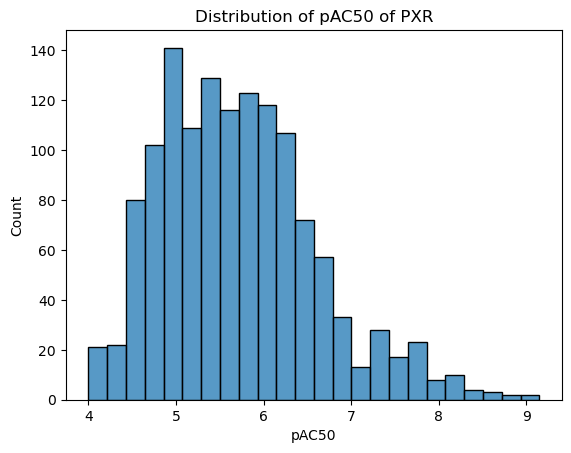

In [3]:
# Check the distribution of your data
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=processed_data, x="OPENADMET_LOGAC50")
plt.xlabel("pAC50")
plt.title("Distribution of pAC50 of PXR")

✨✨✨✨✨✨✨